Importing packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

Importing the data

In [2]:
wine = pd.read_csv('winequality-red.csv')

The head of the data

In [3]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Observe which aspects of a wine are most correlated with wine quality

In [4]:
quality_correlation = wine.corr().loc['quality'][:-1]

# extract 5 most aspects of wine quality

most_important = np.abs(quality_correlation).sort_values(ascending=False)[:5].index

# display correlation of observables and wine quality
quality_correlation

fixed acidity           0.124052
volatile acidity       -0.390558
citric acid             0.226373
residual sugar          0.013732
chlorides              -0.128907
free sulfur dioxide    -0.050656
total sulfur dioxide   -0.185100
density                -0.174919
pH                     -0.057731
sulphates               0.251397
alcohol                 0.476166
Name: quality, dtype: float64

To see how separable wines of different qualities are, I generated a pairplot of the five most import aspects of wine

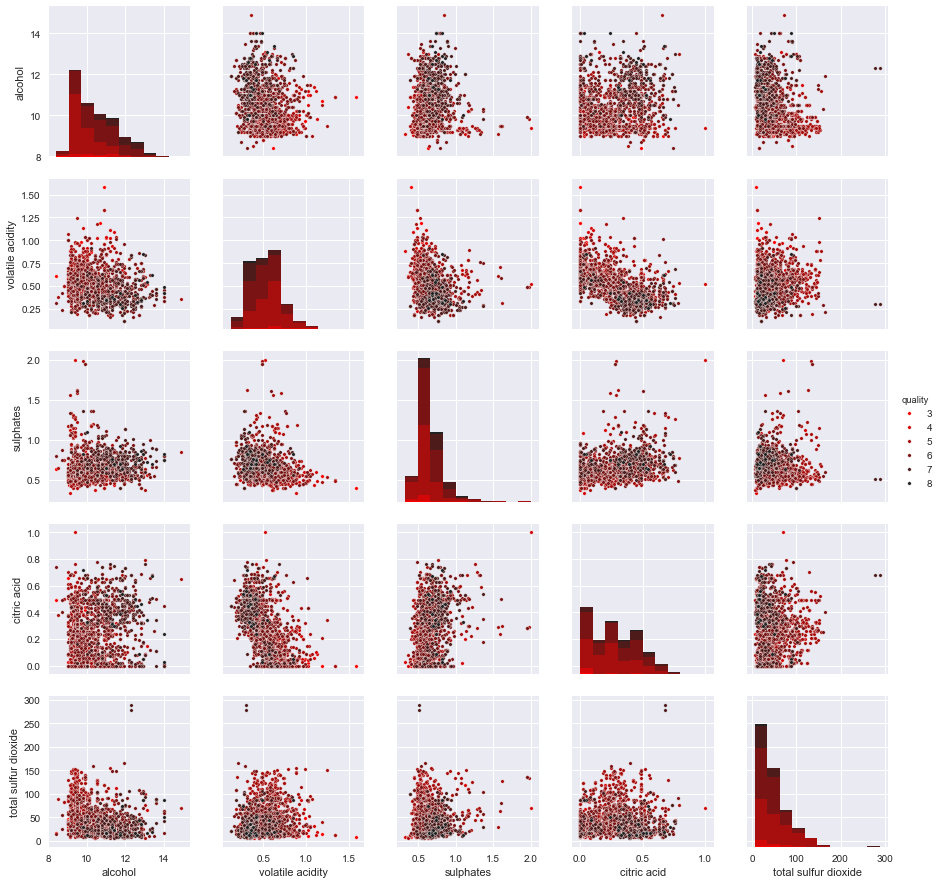

In [5]:
sns.pairplot(wine,hue='quality',vars=most_important,palette=sns.dark_palette('red',reverse=True),markers='.')

Having so many different qualities of wine makes these plots difficult to interpret visually. As a result, I divided the data into three quality brackets: low (3 or 4), medium (5 or 6), and high (7 or 8).

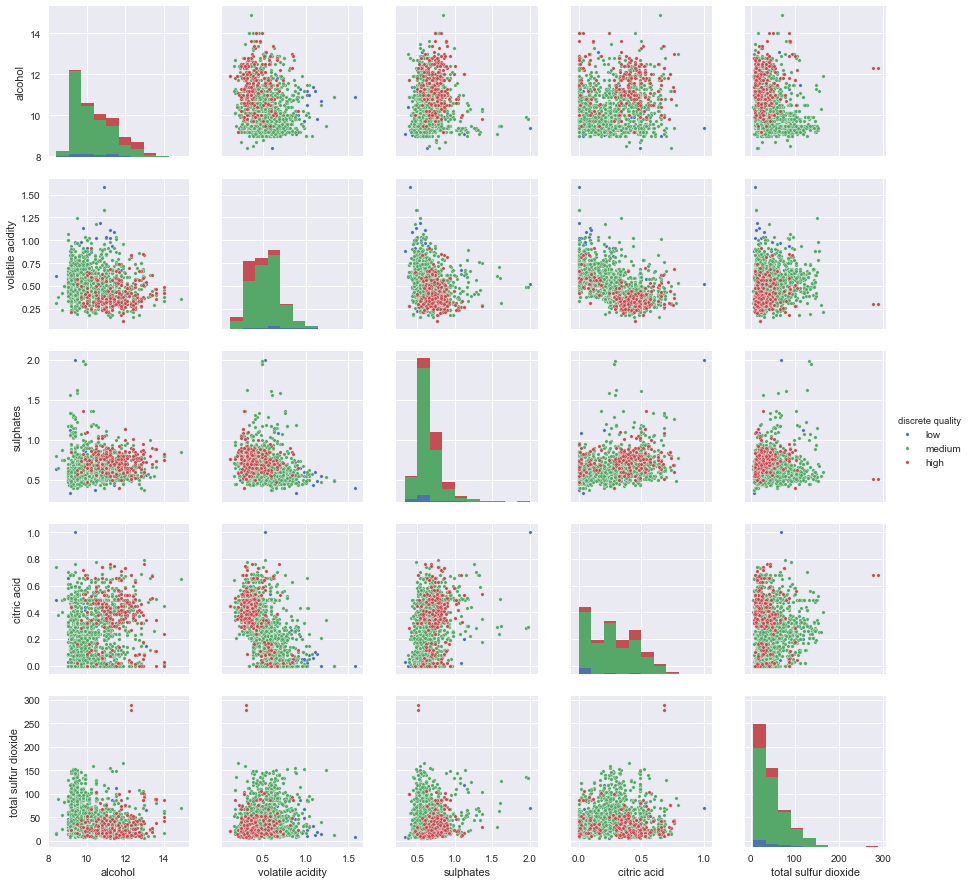

In [6]:
wine['discrete quality'] = 'medium'
wine.loc[wine['quality'] < 5, 'discrete quality'] = 'low'
wine.loc[wine['quality'] > 6, 'discrete quality'] = 'high'
sns.pairplot(wine,hue='discrete quality',vars=most_important,markers='.',hue_order = ['low','medium','high'])

First, there aren't many low quality wines considered. Second, there does seem to be some separation between the medium and high quality wines which might become clearer in higher dimensional space.


I'll apply several different types of classifiers on this data set both determine if the wine is "good" and then to predict its exact quality. I'll begin with a Gaussian naive Bayes model.

In [7]:
# importing a few relevant sklearn packages

from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV

# creating the feature and target vector
X = wine.drop(['quality','discrete quality'],1) #feature matrix
goodwine = wine['discrete quality']=='high'
wine_quality = wine['quality']

# splitting the data for cross validation
goodX1, goodX2, goody1, goody2 = train_test_split(X,goodwine,random_state = 0,train_size = .8)
allX1, allX2, ally1, ally2 = train_test_split(X,wine_quality,random_state = 0,train_size = .8)

C:\Users\Matthew\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Matthew\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


First I'll classify which wines are "good."

In [8]:
# make and fit the model
goodGNB = GaussianNB()
goodGNB.fit(goodX1,goody1)

# evaluate its accuracy
goody2_GNB = goodGNB.predict(goodX2)
accuracy_score(goody2,goody2_GNB)

0.82499999999999996

82% accuracy isn't bad, let's see if it's general

In [9]:
cross_val_score(goodGNB,X,goodwine,cv = 5)

array([ 0.87227414,  0.69781931,  0.90282132,  0.70219436,  0.86833856])

Somewhat, let's see how it does for the precise quality

In [10]:
# make and fit the model
allGNB = GaussianNB()
allGNB.fit(allX1,ally1)

# evaluate its accuracy
ally2_GNB = allGNB.predict(allX2)
print('accuracy score is '+str(accuracy_score(ally2,ally2_GNB)))
cross_val_score(allGNB,X,wine_quality,cv = 5)

accuracy score is 0.5375


array([ 0.51552795,  0.46728972,  0.57009346,  0.49371069,  0.58990536])

Not bad, I'll visualize where the missed labels were with a confusion matrix

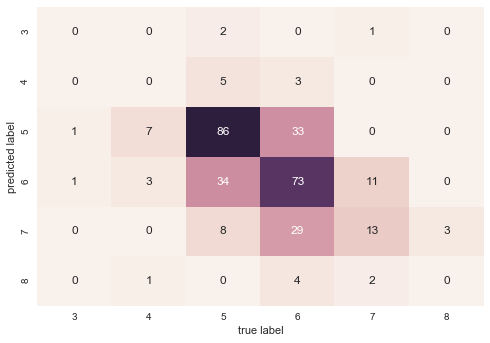

In [11]:
# import the confusion matrix package
from sklearn.metrics import confusion_matrix

# make the confusion matrix
GNBmat = confusion_matrix(ally2,ally2_GNB)

# plot it out
sns.heatmap(GNBmat.T,annot = True,fmt='d',cbar = False,xticklabels = allGNB.classes_,yticklabels = allGNB.classes_)
plt.xlabel('true label')
plt.ylabel('predicted label')

It looks like the model has some trouble differentiated a "5" from a "6" and a "6" from a "7" which makes sense; they're similar qualities of wine. There are other weird missed assignments, sometimes confusing really good and really bad wine. I might be able to improve with a more complex method. Let's try a support vector machine.

In [12]:
# import support vector classification
from sklearn.svm import SVC

# make and fit the model
goodSVM = SVC()
goodSVM.fit(goodX1,goody1)

# evaluate its accuracy
goody2_SVM = goodSVM.predict(goodX2)
print('accuracy score is ' + str(accuracy_score(goody2,goody2_SVM)))
cross_val_score(goodSVM,X,goodwine,cv = 5)

accuracy score is 0.9125


array([ 0.86292835,  0.86292835,  0.87147335,  0.84326019,  0.86520376])

I can optimize the hyperparameters with a grid search

In [13]:
# Import grid search
from sklearn.grid_search import GridSearchCV

# set up the parameters grid to search over
params_grid_SVM = {'kernel':['linear','rbf'],'C':[.05,.1,.5,1,5,10]}
good_grid_SVM = GridSearchCV(SVC(),params_grid_SVM,cv = 5)

# fit the grid
good_grid_SVM.fit(X,goodwine)

# evaluate the possible model hyperparameters
good_grid_SVM.grid_scores_

[mean: 0.86429, std: 0.00111, params: {'C': 0.05, 'kernel': 'linear'},
 mean: 0.86429, std: 0.00111, params: {'C': 0.05, 'kernel': 'rbf'},
 mean: 0.86429, std: 0.00111, params: {'C': 0.1, 'kernel': 'linear'},
 mean: 0.86429, std: 0.00111, params: {'C': 0.1, 'kernel': 'rbf'},
 mean: 0.86429, std: 0.00111, params: {'C': 0.5, 'kernel': 'linear'},
 mean: 0.85491, std: 0.01373, params: {'C': 0.5, 'kernel': 'rbf'},
 mean: 0.86429, std: 0.00111, params: {'C': 1, 'kernel': 'linear'},
 mean: 0.86116, std: 0.00948, params: {'C': 1, 'kernel': 'rbf'},
 mean: 0.85929, std: 0.00963, params: {'C': 5, 'kernel': 'linear'},
 mean: 0.83365, std: 0.03236, params: {'C': 5, 'kernel': 'rbf'},
 mean: 0.85929, std: 0.00963, params: {'C': 10, 'kernel': 'linear'},
 mean: 0.82051, std: 0.03758, params: {'C': 10, 'kernel': 'rbf'}]

There's little difference between kernels and variation in C values is small. I'll use a value of C=0.1 and the default radial basis function as the kernel. Now I'll generate a final model.

In [14]:
# generate and fit a final model
goodSVM = SVC(C = 0.1)
goodSVM.fit(goodX1,goody1)

# evaluate its accuracy
goody2_SVM = goodSVM.predict(goodX2)
print('accuracy score is ' + str(accuracy_score(goody2,goody2_SVM)))
cross_val_score(goodSVM,X,goodwine,cv = 5)

accuracy score is 0.90625


array([ 0.86292835,  0.86292835,  0.86520376,  0.86520376,  0.86520376])

A little worse on the specific testing set we chose, but again, it is a little more robust in terms of data selected. Now, I'll move on to predicting the exact quality of the wine. This time I'll start with a hyperparameter optimization.

In [15]:
# do a grid search, we'll use the same parameter grid as before 
all_grid_SVM = GridSearchCV(SVC(),params_grid_SVM,cv = 5)
all_grid_SVM.fit(X,wine_quality)
all_grid_SVM.grid_scores_

[mean: 0.56723, std: 0.03907, params: {'C': 0.05, 'kernel': 'linear'},
 mean: 0.42589, std: 0.00214, params: {'C': 0.05, 'kernel': 'rbf'},
 mean: 0.56660, std: 0.03703, params: {'C': 0.1, 'kernel': 'linear'},
 mean: 0.42652, std: 0.00570, params: {'C': 0.1, 'kernel': 'rbf'},
 mean: 0.56911, std: 0.03449, params: {'C': 0.5, 'kernel': 'linear'},
 mean: 0.49906, std: 0.01677, params: {'C': 0.5, 'kernel': 'rbf'},
 mean: 0.57161, std: 0.03420, params: {'C': 1, 'kernel': 'linear'},
 mean: 0.49281, std: 0.01995, params: {'C': 1, 'kernel': 'rbf'},
 mean: 0.56973, std: 0.03811, params: {'C': 5, 'kernel': 'linear'},
 mean: 0.46216, std: 0.01708, params: {'C': 5, 'kernel': 'rbf'},
 mean: 0.56660, std: 0.04003, params: {'C': 10, 'kernel': 'linear'},
 mean: 0.43902, std: 0.02166, params: {'C': 10, 'kernel': 'rbf'}]

It looks like the way to go is a linear kernel with C=1.

In [16]:
# generate and fit the model
allSVM = SVC(C = 1,kernel = 'linear')
allSVM.fit(allX1,ally1)

# evaluate its accuracy
ally2_SVM = allSVM.predict(allX2)
print('accuracy score is ' + str(accuracy_score(ally2,ally2_SVM)))
cross_val_score(allSVM,X,wine_quality,cv = 5)

accuracy score is 0.6375


array([ 0.54347826,  0.52024922,  0.60747664,  0.58490566,  0.60252366])

Better than Gaussian naive Bayes. Let's look at the confusion matrix.

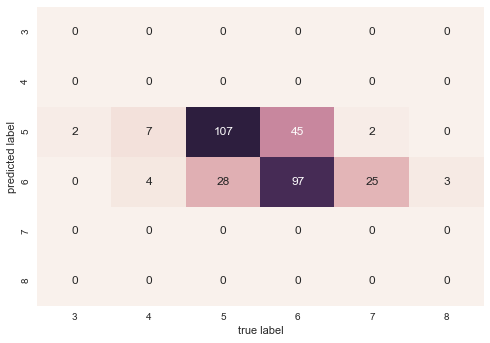

In [17]:
SVMmat = confusion_matrix(ally2,ally2_SVM)
sns.heatmap(SVMmat.T,annot = True,fmt = 'd',cbar = False,xticklabels = allSVM.classes_,yticklabels = allSVM.classes_)
plt.xlabel('true label')
plt.ylabel('predicted label')

That looks better as well. I'll apply one more common classifier, a random forest.

In [18]:
# import random forest classification
from sklearn.ensemble import RandomForestClassifier

# generate and fit the model, we'll keep a constant random state throughout this process
goodRF = RandomForestClassifier(random_state = 0)
goodRF.fit(goodX1,goody1)

# evaluate its accuracy
goody2_RF = goodRF.predict(goodX2)
print('accuracy score is ' + str(accuracy_score(goody2,goody2_RF)))
cross_val_score(goodRF,X,goodwine,cv = 5)

accuracy score is 0.921875


array([ 0.88785047,  0.85046729,  0.85579937,  0.84952978,  0.88401254])

Again, I'll tune the hyperparameters

In [20]:
# new model, new hyperparemters
params_grid_RF = {'n_estimators':[10,50,100,500,1000,5000,10000],'random_state':[0]}
good_grid_RF = GridSearchCV(RandomForestClassifier(),params_grid_RF,cv = 5)

# fitting the grid and evaluating it
good_grid_RF.fit(X,goodwine)
good_grid_RF.grid_scores_

[mean: 0.86554, std: 0.01684, params: {'n_estimators': 10, 'random_state': 0},
 mean: 0.86742, std: 0.01425, params: {'n_estimators': 50, 'random_state': 0},
 mean: 0.86554, std: 0.01334, params: {'n_estimators': 100, 'random_state': 0},
 mean: 0.87305, std: 0.01278, params: {'n_estimators': 500, 'random_state': 0},
 mean: 0.87054, std: 0.01190, params: {'n_estimators': 1000, 'random_state': 0},
 mean: 0.87054, std: 0.00937, params: {'n_estimators': 5000, 'random_state': 0},
 mean: 0.87054, std: 0.00921, params: {'n_estimators': 10000, 'random_state': 0}]

I'll use 500 estimators

In [21]:
# generate and fit the model
goodRF = RandomForestClassifier(n_estimators=300,random_state=0)
goodRF.fit(goodX1,goody1)

# evaluate its accuracy
goody2_RF = goodRF.predict(goodX2)
print('accuracy score is ' + str(accuracy_score(goody2,goody2_RF)))
cross_val_score(goodRF,X,goodwine,cv = 5)

accuracy score is 0.93125


array([ 0.8847352 ,  0.84735202,  0.89028213,  0.86206897,  0.87460815])

Pretty good. Finally, I'll try to predict the exact wine quality. I'll start with a grid search.

In [22]:
all_grid_RF = GridSearchCV(RandomForestClassifier(),params_grid_RF,cv = 5)
all_grid_RF.fit(X,wine_quality)
all_grid_RF.grid_scores_

[mean: 0.53158, std: 0.03039, params: {'n_estimators': 10, 'random_state': 0},
 mean: 0.57098, std: 0.02821, params: {'n_estimators': 50, 'random_state': 0},
 mean: 0.56973, std: 0.02965, params: {'n_estimators': 100, 'random_state': 0},
 mean: 0.56723, std: 0.03635, params: {'n_estimators': 500, 'random_state': 0},
 mean: 0.57411, std: 0.03156, params: {'n_estimators': 1000, 'random_state': 0},
 mean: 0.57411, std: 0.03196, params: {'n_estimators': 5000, 'random_state': 0},
 mean: 0.57411, std: 0.03260, params: {'n_estimators': 10000, 'random_state': 0}]

Now I'll generate the model and check its accuracy

In [23]:
# generate and fit the model
allRF = RandomForestClassifier(random_state = 0,n_estimators = 1000)
allRF.fit(allX1,ally1)

# evaluate its accuracy
ally2_RF = allRF.predict(allX2)
print('accuracy score is ' + str(accuracy_score(ally2,ally2_RF)))
cross_val_score(allRF,X,wine_quality,cv = 5)

accuracy score is 0.725


array([ 0.52795031,  0.54517134,  0.60747664,  0.59433962,  0.59621451])

Pretty comparable to SVM. Finally, I'll generate a confusion matrix

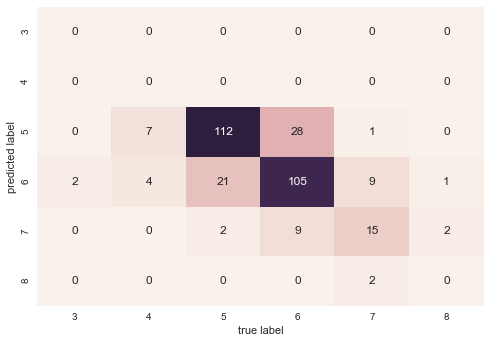

In [24]:
RFmat = confusion_matrix(ally2,ally2_RF)
sns.heatmap(RFmat.T,annot = True,fmt = 'd',cbar = False,xticklabels = allRF.classes_,yticklabels = allRF.classes_)
plt.xlabel('true label')
plt.ylabel('predicted label')